In [1]:
# General libraries
import pandas as pd
import numpy as np

from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
import joblib

# Utils functions
from utils.utils import kfold, read_datasets, plot_pred_expected_results

In [2]:
x_train, x_test, y_train, y_test = read_datasets(
    'x_train_2.csv',
    'x_test_2.csv',
    'y_train_2.csv',
    'y_test_2.csv'
)

In [3]:
folds = kfold()

In [4]:
# Specify range of hyperparameters to tune
hyper_params = {
    'hidden_layer_sizes': [(80,), (100,), (110,), (150,)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.002, 0.005, 0.006],
    'power_t': [0.5, 0.6],
    'max_iter': [200],
    'shuffle': [True],
    'momentum': [0.5, 0.8, 0.9, 1],
    'early_stopping': [False]

}



# Call RandomSearchCV()
model_cv = RandomizedSearchCV(
    estimator = MLPRegressor(),
    param_distributions = hyper_params,
    n_iter=300,
    scoring= 'r2',
    cv = folds,
    verbose = 2,
    return_train_score=True,
    n_jobs = -1,
    refit = True
    )


# Fit the model
best_model = model_cv.fit(x_train, np.ravel(y_train)) 

print(model_cv.best_params_)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


/Users/renan/Library/Python/3.7/lib/python/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ 1.01507635e-01  1.05319393e-01 -2.76140857e+00 -2.85765951e-01
  5.03429064e-02  1.05361057e-01 -1.50629592e+00 -1.80081365e+00
  2.79085436e-02  1.12475976e-01 -5.73687761e-01  3.36345097e-02
 -8.67370672e-02  9.17672639e-02  7.19660865e-02 -9.47130728e-02
  1.05490549e-01  8.73685014e-02 -4.84438801e-01  1.21247529e-01
 -2.52217101e-02 -3.68665061e+01  8.16847604e-02  2.10742189e-02
 -3.75300217e-03  5.22135079e-02  2.36319918e-02  7.78176003e-02
  1.00811397e-01  7.02129642e-02 -4.36481077e-01 -4.25184734e-03
  2.81300411e-02 -3.61275698e-01 -4.20161698e-01             nan
  1.75316578e-03 -3.13692869e-01  1.05659352e-01  9.20483110e-02
  1.05718526e-01  1.10900873e-01 -1.62380475e-01 -6.94131453e-03
 -2.57971685e-01  1.05369745e-01  1.10090856e-01  1.07740903e-01
 -1.56783100e+00  6.26071315e-02 -2.90860520e-01 -7.54206769e-0

{'solver': 'sgd', 'shuffle': True, 'power_t': 0.6, 'momentum': 0.8, 'max_iter': 200, 'learning_rate_init': 0.005, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'early_stopping': False, 'alpha': 0.0001, 'activation': 'tanh'}


/Users/renan/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [5]:
# Create new model with best_params_ from grid search

mlp_best = best_model.best_estimator_

In [6]:
# Get the results for each split

def get_best_model_cv_split_results(best_model, n_splits=10, set_type='train'):
    results = []
    best_index = best_model.best_index_
    for i in range(0, n_splits):
        current_split = 'split{}_{}_score'.format(i, set_type)
        split_result = best_model.cv_results_[current_split][best_index]
        results.append(split_result)

    return results

print("Train Results: {}".format(get_best_model_cv_split_results(best_model, 10, 'train')))
print("Test Results: {}".format(get_best_model_cv_split_results(best_model, 10, 'test')))

Train Results: [0.2687593639728777, 0.27171353964848133, 0.2652342572364629, 0.2545255595885879, 0.27651517419780514, 0.34257741480282833, 0.2876970882441269, 0.26592779490390617, 0.25930135397731535, 0.25684909922158483]
Test Results: [0.22703180843676518, 0.12320583518764461, 0.32368766570922414, 0.2539028486379492, 0.21487741166484764, -0.2838405915847535, 0.16821617495453245, 0.10338489008313445, 0.18377558061940158, 0.299721750125318]


In [7]:
#Get the mean and std for the train and test

train_mean = sum(get_best_model_cv_split_results(best_model, 10, 'train'))/10
test_mean = sum(get_best_model_cv_split_results(best_model, 10, 'test'))/10

print("Train mean: {}".format(train_mean))
print("Train std: {}".format(np.std(get_best_model_cv_split_results(best_model, 10, 'train'))))

print("-=-=-=-=-=-=-=-=-=-=-=")

print("Validation mean: {}".format(test_mean))
print("Validation std: {}".format(np.std(get_best_model_cv_split_results(best_model, 10, 'test'))))

Train mean: 0.2749100645793976
Train std: 0.0243980825132463
-=-=-=-=-=-=-=-=-=-=-=
Validation mean: 0.1613963373834064
Validation std: 0.16272836143595443


In [8]:
y_pred = mlp_best.predict(x_test)
r2 = r2_score(y_test, y_pred)
print("The r2 score on test set: {:.4f}".format(r2))

The r2 score on test set: 0.1601


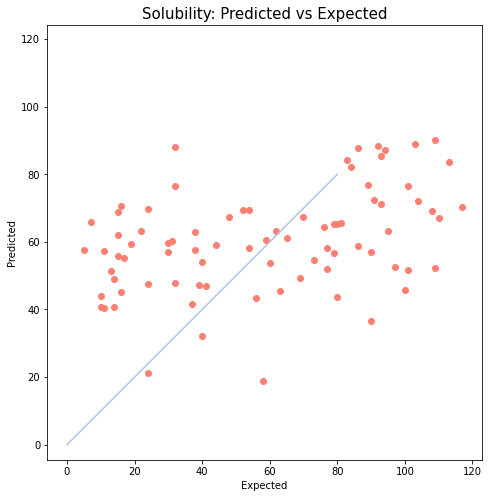

In [9]:
# Plot the R2 predicted and expected results
plot_pred_expected_results(y_test, y_pred)

# Saving trained model

In [10]:
filename = '../models/mlpRegressor_model_high_removed.joblib'
joblib.dump(mlp_best, filename)

['../models/mlpRegressor_model_high_removed.joblib']